In [1]:
# imports

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

In [2]:
# config

config = {
    'seed': 12345
}

In [3]:
# load data

df = pd.read_csv('data/reviews_simple_preprocessed.csv')

df['rating_item'] = df['rating_item'].fillna(0)
df['rating_delivery'] = df['rating_delivery'].fillna(0)
df['rating_seller'] = df['rating_seller'].fillna(0)
df['rating_marketplace'] = df['rating_marketplace'].fillna(0)

df['rating_item'] = df['rating_item'].astype(int)
df['rating_delivery'] = df['rating_delivery'].astype(int)
df['rating_seller'] = df['rating_seller'].astype(int)
df['rating_marketplace'] = df['rating_marketplace'].astype(int)

In [4]:
# transform data

df['title'] = df['title'].fillna('')
df['review'] = ((df['title'] + ' ') if len(df['title']) > 0 else '') + df['body']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['review'])
y = df[['rating_item', 'rating_delivery', 'rating_seller', 'rating_marketplace']]

In [5]:
# split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=config['seed'])

In [6]:
# train model

tuning_grid = {
    'estimator__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'estimator__C': range(1, 11, 1),
    'estimator__degree': range(11),
    'estimator__gamma': ['scale', 'auto'],
}

tuning_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=config['seed'])
gridSearch = RandomizedSearchCV(estimator=MultiOutputClassifier(SVC()), param_distributions=tuning_grid, n_iter=50, n_jobs=-1, random_state=config['seed'], 
    cv=tuning_cv, scoring="accuracy", verbose=1)
searchResults = gridSearch.fit(X_train, y_train)
model = searchResults.best_estimator_
print('The best model: ' + str(model))

Fitting 15 folds for each of 50 candidates, totalling 750 fits


/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/utils/_param_

The best model: MultiOutputClassifier(estimator=SVC(C=5, degree=8, kernel='linear'))


In [7]:
# test model

y_predicted = model.predict(X_test)

Accuracy:  {'rating_item': 0.44166666666666665, 'rating_delivery': 0.36666666666666664, 'rating_seller': 0.4625, 'rating_marketplace': 0.45}
Average accuracy:  0.43020833333333336


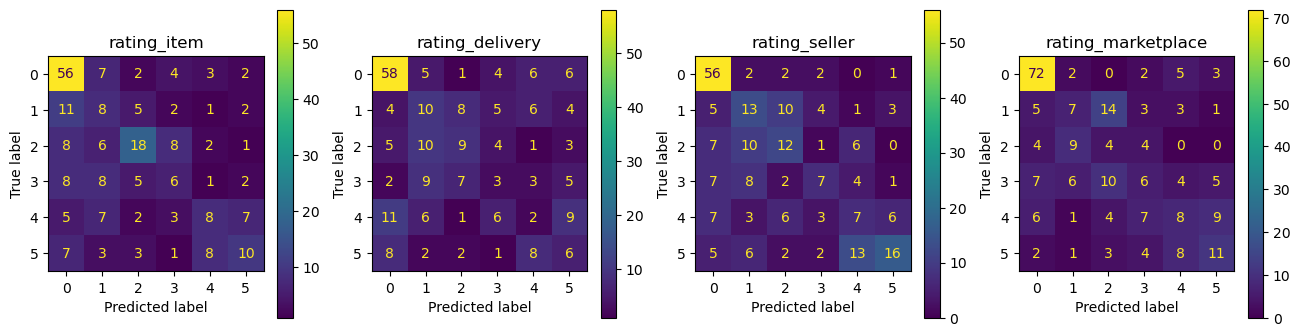

In [8]:
# show results

accuracy = {}

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

cm = confusion_matrix(y_test['rating_item'], y_predicted[:, 0], labels=model.classes_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_[0])
disp.plot(ax=axs[0])
axs[0].set_title('rating_item')
accuracy['rating_item'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(y_test['rating_delivery'], y_predicted[:, 1], labels=model.classes_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_[0])
disp.plot(ax=axs[1])
axs[1].set_title('rating_delivery')
accuracy['rating_delivery'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(y_test['rating_seller'], y_predicted[:, 2], labels=model.classes_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_[0])
disp.plot(ax=axs[2])
axs[2].set_title('rating_seller')
accuracy['rating_seller'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(y_test['rating_marketplace'], y_predicted[:, 3], labels=model.classes_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_[0])
disp.plot(ax=axs[3])
axs[3].set_title('rating_marketplace')
accuracy['rating_marketplace'] = cm.diagonal().sum() / cm.sum()

print('Accuracy: ', accuracy)
print('Average accuracy: ', sum(accuracy.values()) / len(accuracy))

plt.show()

In [9]:
with open('model/svm_simple.pkl', 'wb') as f:
    clf = pickle.dump(model, f)